Машинное обучние

In [17]:
# 1. ИМПОРТ БИБЛИОТЕК
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import os

# Визуализация
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp
from plotly.offline import plot

# Машинное обучение (для кластеризации в RFM)
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import (
    StandardScaler,
    FunctionTransformer,
    LabelEncoder,
    MinMaxScaler,
    RobustScaler,
    MaxAbsScaler,
    QuantileTransformer
)

from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score, roc_curve, auc, confusion_matrix, classification_report, roc_auc_score
from statsmodels.tsa.arima.model import ARIMA



In [18]:
# Настройки отображения
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [26]:
'''1. Загрузка данных'''
merged_cleaned_data = pd.read_csv('11_merged_cleaned_data.csv')

In [ ]:
print(merged_cleaned_data.info())

In [41]:
print(merged_cleaned_data.head())

   ProductKey  OrderDate    ShipDate  CustomerKey  SalesTerritoryKey  \
0         310 2014-01-01  2014-01-08        21768                  6   
1         346 2014-01-01  2014-01-08        28389                  7   
2         346 2014-01-01  2014-01-08        25863                  1   
3         336 2014-01-01  2014-01-08        14501                  4   
4         346 2014-01-01  2014-01-08        11003                  9   

  SalesOrderNumber  OrderQuantity  UnitPrice  TotalProductCost  SalesAmount  \
0          SO43697              2  1789.1350         2171.2942    3578.2700   
1          SO43698              2  1699.9950         1912.1544    3399.9900   
2          SO43699              2  1699.9950         1912.1544    3399.9900   
3          SO43700              2   349.5491          413.1463     699.0982   
4          SO43701              2  1699.9950         1912.1544    3399.9900   

     TaxAmt FirstName  LastName           FullName   BirthDate MaritalStatus  \
0  286.2616 

In [27]:
df = merged_cleaned_data

Корреляционный анализ

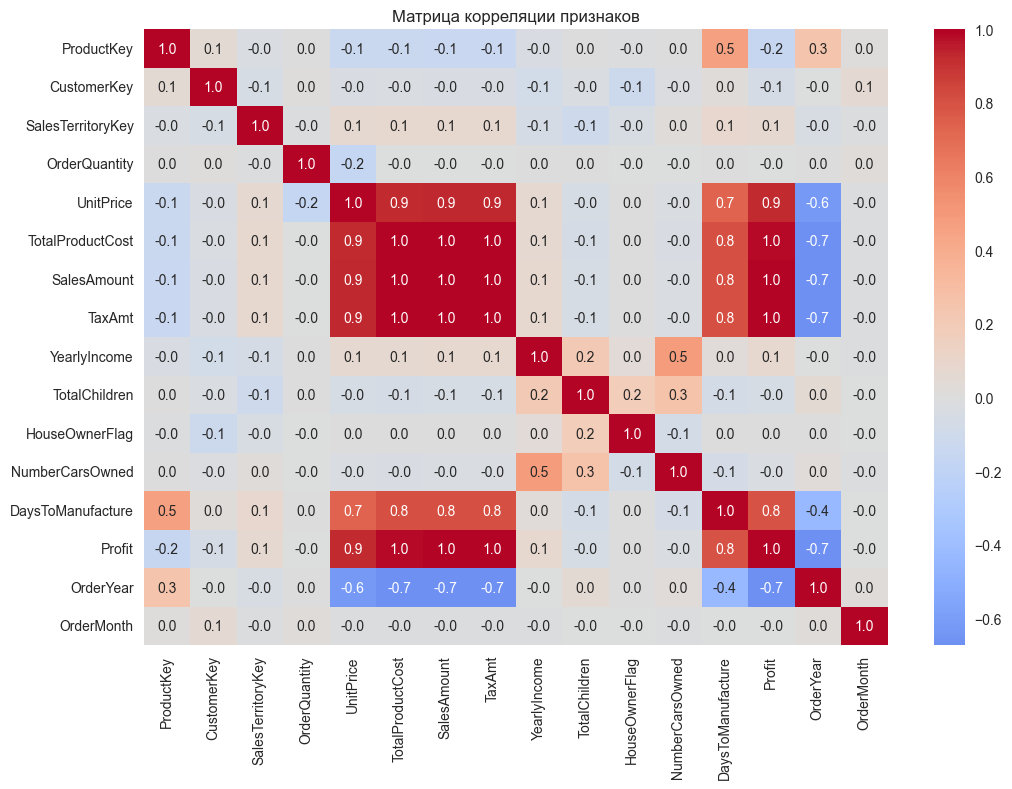

✅ Корреляционный анализ завершён


In [28]:
# Убедимся, что все числовые столбцы
numeric_df = df.select_dtypes(include=[float, int])

# Корреляционная матрица
correlation_matrix = numeric_df.corr()

# Визуализация
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".1f", cmap='coolwarm', center=0)
plt.title('Матрица корреляции признаков')
plt.show()

print("✅ Корреляционный анализ завершён")

In [33]:
# Найдём признаки с корреляцией > 0.7
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            high_corr_pairs.append((correlation_matrix.columns[i], 
                                    correlation_matrix.columns[j], 
                                    correlation_matrix.iloc[i, j]))

print("⚠️ Сильно коррелирующие пары:")
for pair in high_corr_pairs:
    print(f"   • {pair[0]} и {pair[1]}: {pair[2]:.2f}")

⚠️ Сильно коррелирующие пары:
   • UnitPrice и TotalProductCost: 0.93
   • UnitPrice и SalesAmount: 0.93
   • UnitPrice и TaxAmt: 0.93
   • UnitPrice и DaysToManufacture: 0.74
   • UnitPrice и Profit: 0.92
   • TotalProductCost и SalesAmount: 1.00
   • TotalProductCost и TaxAmt: 1.00
   • TotalProductCost и DaysToManufacture: 0.81
   • TotalProductCost и Profit: 0.99
   • SalesAmount и TaxAmt: 1.00
   • SalesAmount и DaysToManufacture: 0.81
   • SalesAmount и Profit: 1.00
   • TaxAmt и DaysToManufacture: 0.81
   • TaxAmt и Profit: 1.00
   • DaysToManufacture и Profit: 0.80


стандартизация нормализация  признаков

In [ ]:
# StandardScaler
# Убедимся, что 'OrderDate' — формат datetime
df['OrderDate'] = pd.to_datetime(df['OrderDate'], errors='coerce')

# Максимальная дата в данных — это "сегодня"
snapshot_date = df['OrderDate'].max()

# Удаляем старый Recency, если он есть
if 'Recency' in df.columns:
    df = df.drop(columns=['Recency'])

# Группируем по CustomerKey и считаем Recency (дней с последнего заказа)
recency_data = df.groupby('CustomerKey').agg({
    'OrderDate': lambda x: (snapshot_date - x.max()).days
}).reset_index()

recency_data.columns = ['CustomerKey', 'Recency']

# Объединяем с основным DataFrame
df = df.merge(recency_data, on='CustomerKey', how='left')

# Создаём столбец Churn
df['Churn'] = (df['Recency'] > 300).astype(int)

# Выбираем только числовые столбцы
numeric_df = df.select_dtypes(include=[np.number])

# Удаляем CustomerKey и Churn из numeric_df, если они там есть
if 'CustomerKey' in numeric_df.columns:
    numeric_df = numeric_df.drop(columns=['CustomerKey'])
if 'Churn' in numeric_df.columns:
    numeric_df = numeric_df.drop(columns=['Churn'])

# Заполняем NaN (например, средним значением)
numeric_df = numeric_df.fillna(numeric_df.mean())

# Проверяем, остались ли NaN
print("NaN в numeric_df после заполнения:", numeric_df.isna().sum().sum())

# Применяем StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_df)

# Преобразуем обратно в DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=numeric_df.columns, index=numeric_df.index)

print("\n✅ Данные нормализованы с помощью StandardScaler.")
print("Первые 5 строк нормализованных данных:")
print(scaled_df.head())

# Объединяем scaled_df с CustomerKey и Churn
df_features = df[['CustomerKey', 'Churn']].copy()
df_features = df_features.join(scaled_df)

print("\n✅ Подготовка признаков завершена.")

NaN в numeric_df после заполнения: 0

✅ Данные нормализованы с помощью StandardScaler.
Первые 5 строк нормализованных данных:
   ProductKey  SalesTerritoryKey  OrderQuantity  UnitPrice  TotalProductCost  \
0   -1.077135          -0.088411       0.411078   1.650866          3.346781   
1   -0.772306           0.249401       0.411078   1.543861          2.884169   
2   -0.772306          -1.777473       0.411078   1.543861          2.884169   
3   -0.856980          -0.764036       0.411078  -0.077234          0.208165   
4   -0.772306           0.925026       0.411078   1.543861          2.884169   

   SalesAmount    TaxAmt  YearlyIncome  TotalChildren  HouseOwnerFlag  \
0     3.265801  3.265801      0.308808       1.957987        0.669403   
1     3.076434  3.076434     -1.200500       0.719178       -1.493869   
2     3.076434  3.076434     -0.596777       1.957987        0.669403   
3     0.207585  0.207586      0.610670       1.338583        0.669403   
4     3.076434  3.076434    

In [44]:
print("Количество NaN в scaled_df:", scaled_df.isna().sum().sum())
print("Столбцы с NaN:")
print(scaled_df.columns[scaled_df.isna().any()].tolist())

Количество NaN в scaled_df: 0
Столбцы с NaN:
[]


Обучение

Логарифмическая регрессия 

In [45]:
# Подготовка признаков и целевой переменной
X = df_features.drop(['CustomerKey', 'Churn'], axis=1)  # признаки
y = df_features['Churn']  # целевая переменная

# # Заполняем NaN (например, средним значением)
# X = X.fillna(X.mean())

# Применяем SMOTE (только к обучающей выборке!)
smote = SMOTE(random_state=23423)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Разделение на train и test
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=43, stratify=y_resampled
)

print('Размеры тренировочной выборки X:', len(X_train))
print('Размеры тестовой выборки X:', len(X_test))
print('Размеры тренировочной выборки y:', len(y_train))
print('Размеры тестовой выборки y:', len(y_test))

# Обучение модели
model = LogisticRegression(
    max_iter=10000, penalty='l2', tol=0.001, solver='lbfgs', C=0.7, random_state=42
)
model.fit(X_train, y_train)

# Предсказания
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # вероятности класса 1

# Оценка
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"\nТочность модели: {accuracy:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")
print("\nКлассификационный отчёт:")
print(classification_report(y_test, y_pred))

Размеры тренировочной выборки X: 85155
Размеры тестовой выборки X: 21289
Размеры тренировочной выборки y: 85155
Размеры тестовой выборки y: 21289

Точность модели: 0.9945
AUC-ROC: 1.0000

Классификационный отчёт:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     10645
           1       0.99      1.00      0.99     10644

    accuracy                           0.99     21289
   macro avg       0.99      0.99      0.99     21289
weighted avg       0.99      0.99      0.99     21289



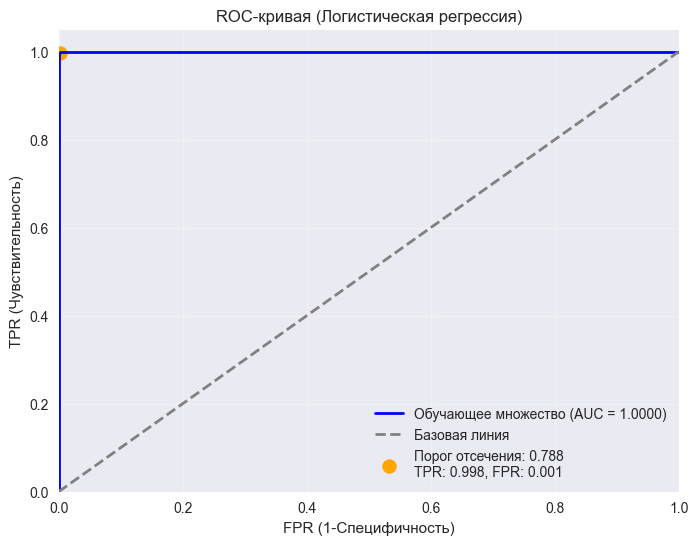


✅ Оптимальный порог отсечения: 0.788


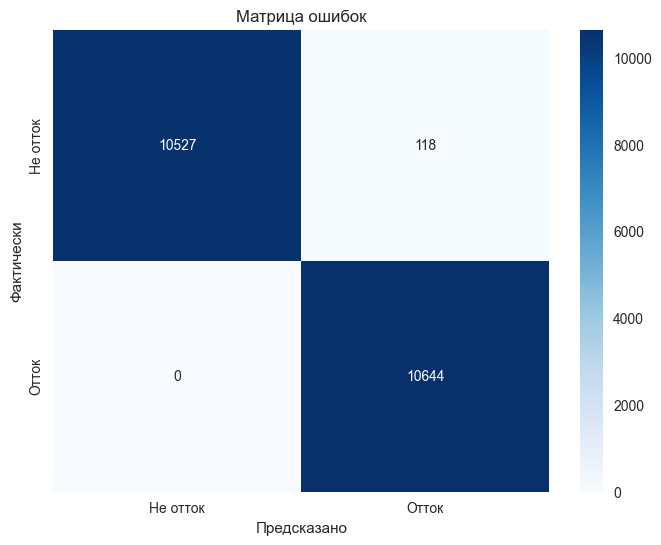


📊 Таблица метрик:
  Метрика  Значение
  AUC ROC  0.999985
Precision  0.989035
   Recall  1.000000
 F1 Score  0.994488
      MCC  0.988975

📈 Распознано:
   • Обучающее: 21171/85155 (24.9%)
   • Тестовое: 21171/21289 (99.4%)

🧾 Матрица ошибок (в процентах):
                      Классифицировано: Не отток  Классифицировано: Отток
Фактически: Не отток                        98.9                      1.1
Фактически: Отток                            0.0                    100.0


In [46]:
# --- График ROC-кривой ---
plt.figure(figsize=(8, 6))

# Рассчитываем TPR и FPR
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Построение ROC-кривой
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Обучающее множество (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Базовая линия')

# Находим оптимальный порог (максимум Youden's J = TPR - FPR)
j_scores = tpr - fpr
best_threshold = thresholds[j_scores.argmax()]
best_tpr = tpr[j_scores.argmax()]
best_fpr = fpr[j_scores.argmax()]

# Отмечаем оптимальный порог
plt.scatter(best_fpr, best_tpr, color='orange', s=100, label=f'Порог отсечения: {best_threshold:.3f}\nTPR: {best_tpr:.3f}, FPR: {best_fpr:.3f}')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR (1-Специфичность)')
plt.ylabel('TPR (Чувствительность)')
plt.title('ROC-кривая (Логистическая регрессия)')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

print(f"\n✅ Оптимальный порог отсечения: {best_threshold:.3f}")

# --- Матрица ошибок ---
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Не отток', 'Отток'], 
            yticklabels=['Не отток', 'Отток'])
plt.title('Матрица ошибок')
plt.xlabel('Предсказано')
plt.ylabel('Фактически')
plt.show()

# --- Таблица метрик ---
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef

metrics_data = {
    'Метрика': ['AUC ROC', 'Precision', 'Recall', 'F1 Score', 'MCC'],
    'Значение': [
        roc_auc_score(y_test, y_pred_proba),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred),
        matthews_corrcoef(y_test, y_pred)
    ]
}

metrics_df = pd.DataFrame(metrics_data)
print("\n📊 Таблица метрик:")
print(metrics_df.to_string(index=False))

# --- Распознано (True Positives / Total) ---
tp = cm[1, 1]  # True Positive
tn = cm[0, 0]  # True Negative
fp = cm[0, 1]  # False Positive
fn = cm[1, 0]  # False Negative

total_test = len(y_test)
total_train = len(y_train)

print("\n📈 Распознано:")
print(f"   • Обучающее: {tp + tn}/{total_train} ({(tp + tn)/total_train*100:.1f}%)")
print(f"   • Тестовое: {tp + tn}/{total_test} ({(tp + tn)/total_test*100:.1f}%)")

# --- Дополнительно: Таблица "Фактически vs Классифицировано" ---
print("\n🧾 Матрица ошибок (в процентах):")
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
cm_percent_df = pd.DataFrame(
    cm_percent,
    index=['Фактически: Не отток', 'Фактически: Отток'],
    columns=['Классифицировано: Не отток', 'Классифицировано: Отток']
)
print(cm_percent_df.round(1))

Линейная регрессия 

In [49]:
# Заполняем NaN в df перед созданием X
df = df.fillna(df.median(numeric_only=True))  # заполняем числовые NaN
df = df.fillna('Unknown')  # заполняем строковые NaN

# Целевая переменная (например, SalesAmount)
y = df['SalesAmount']

# Признаки 
features = [
    'UnitPrice', 'SubCategory', 'Category', 'DaysToManufacture', 'Gender', 
    'YearlyIncome', 'TotalChildren', 'Education', 'Occupation', 
    'HouseOwnerFlag', 'NumberCarsOwned', 'CommuteDistance', 
    'CustomerCity', 'CustomerState', 'Region', 'Country'
]

X = df[features].copy()

# Кодируем категориальные признаки
label_encoders = {}
for col in X.columns:
    if X[col].dtype == 'object':
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le

# Нормализуем числовые признаки
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# Разделение на train и test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Обучение модели
model = LinearRegression()
model.fit(X_train, y_train)

# Предсказания
y_pred = model.predict(X_test)

# Оценка
r2 = r2_score(y_test, y_pred)

print(f"Коэффициент детерминации (R²): {r2:.4f}")

Коэффициент детерминации (R²): 0.8987


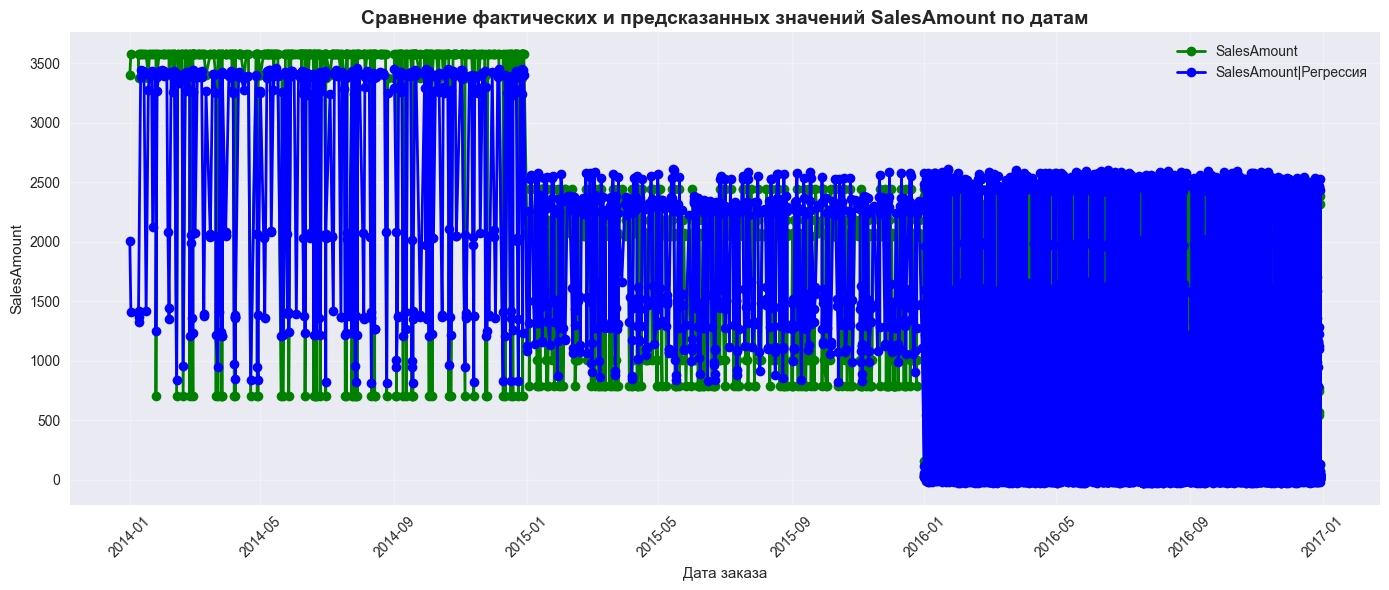

✅ График: Фактические vs Предсказанные значения SalesAmount по датам


In [50]:
# Создаём DataFrame для графика
plot_data = pd.DataFrame({
    'Actual': y_test.reset_index(drop=True),
    'Predicted': y_pred,
    'Date': df.loc[X_test.index, 'OrderDate'].reset_index(drop=True)  # берем даты из исходного df по индексу X_test
})

# Сортируем по дате (если нужно)
plot_data = plot_data.sort_values('Date').reset_index(drop=True)

plt.figure(figsize=(14, 6))

# Фактические значения
plt.plot(plot_data['Date'], plot_data['Actual'], 
         marker='o', color='green', linewidth=2, label='SalesAmount')

# Предсказанные значения
plt.plot(plot_data['Date'], plot_data['Predicted'], 
         marker='o', color='blue', linewidth=2, label='SalesAmount|Регрессия')

plt.title('Сравнение фактических и предсказанных значений SalesAmount по датам', fontsize=14, fontweight='bold')
plt.xlabel('Дата заказа')
plt.ylabel('SalesAmount')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)  # поворот дат, чтобы не накладывались

plt.tight_layout()
plt.show()

print("✅ График: Фактические vs Предсказанные значения SalesAmount по датам")

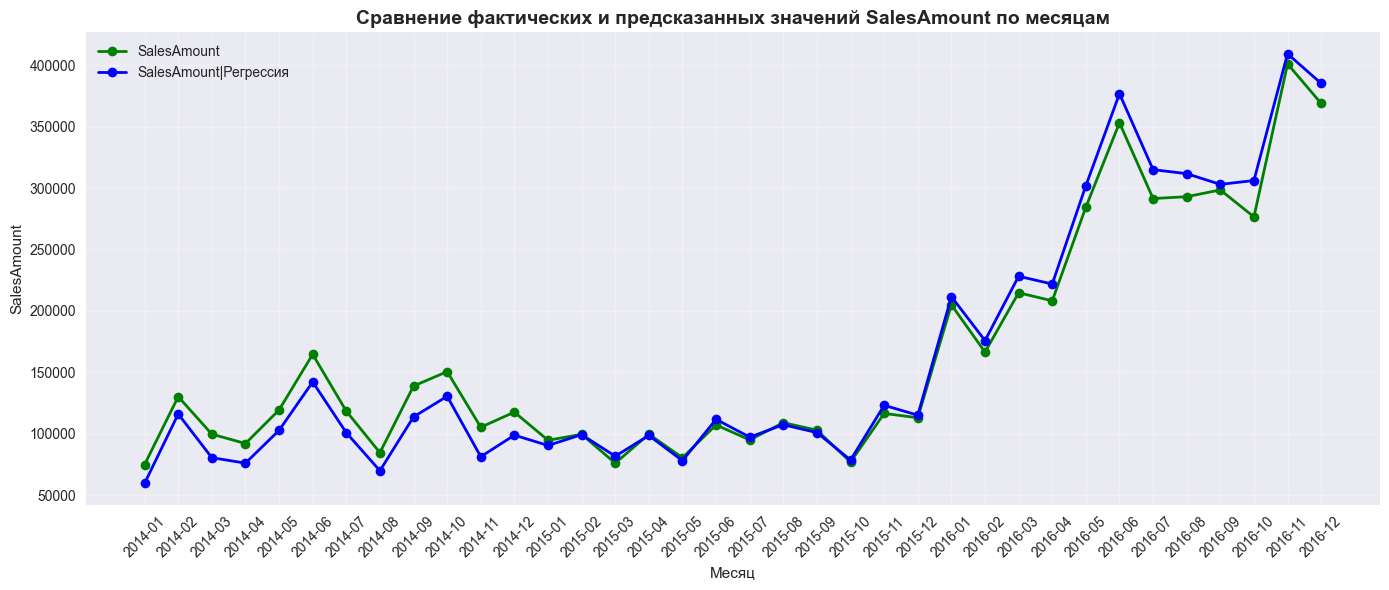

✅ График: Фактические vs Предсказанные значения SalesAmount по месяцам


In [51]:
# Построение графика по месяцам (OrderMonth)

# Создаём DataFrame для графика
plot_data = pd.DataFrame({
    'Actual': y_test.reset_index(drop=True),
    'Predicted': y_pred,
    'OrderMonth': df.loc[X_test.index, 'OrderMonth'].reset_index(drop=True),
    'OrderYear': df.loc[X_test.index, 'OrderYear'].reset_index(drop=True)
})

# Собираем данные по месяцам (суммируем SalesAmount)
monthly_data = plot_data.groupby(['OrderYear', 'OrderMonth']).agg({
    'Actual': 'sum',
    'Predicted': 'sum'
}).reset_index()

# Создаём строку 'Год-Месяц' для оси X
monthly_data['Period'] = monthly_data['OrderYear'].astype(str) + '-' + monthly_data['OrderMonth'].astype(str).str.zfill(2)

plt.figure(figsize=(14, 6))

# Фактические значения
plt.plot(monthly_data['Period'], monthly_data['Actual'], 
         marker='o', color='green', linewidth=2, label='SalesAmount')

# Предсказанные значения
plt.plot(monthly_data['Period'], monthly_data['Predicted'], 
         marker='o', color='blue', linewidth=2, label='SalesAmount|Регрессия')

plt.title('Сравнение фактических и предсказанных значений SalesAmount по месяцам', fontsize=14, fontweight='bold')
plt.xlabel('Месяц')
plt.ylabel('SalesAmount')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)  # поворот меток месяцев

plt.tight_layout()
plt.show()

print("✅ График: Фактические vs Предсказанные значения SalesAmount по месяцам")

ARIMA

Выбросов выявлено 0, экстремальные значения не выявлены.
Данные сглажены.


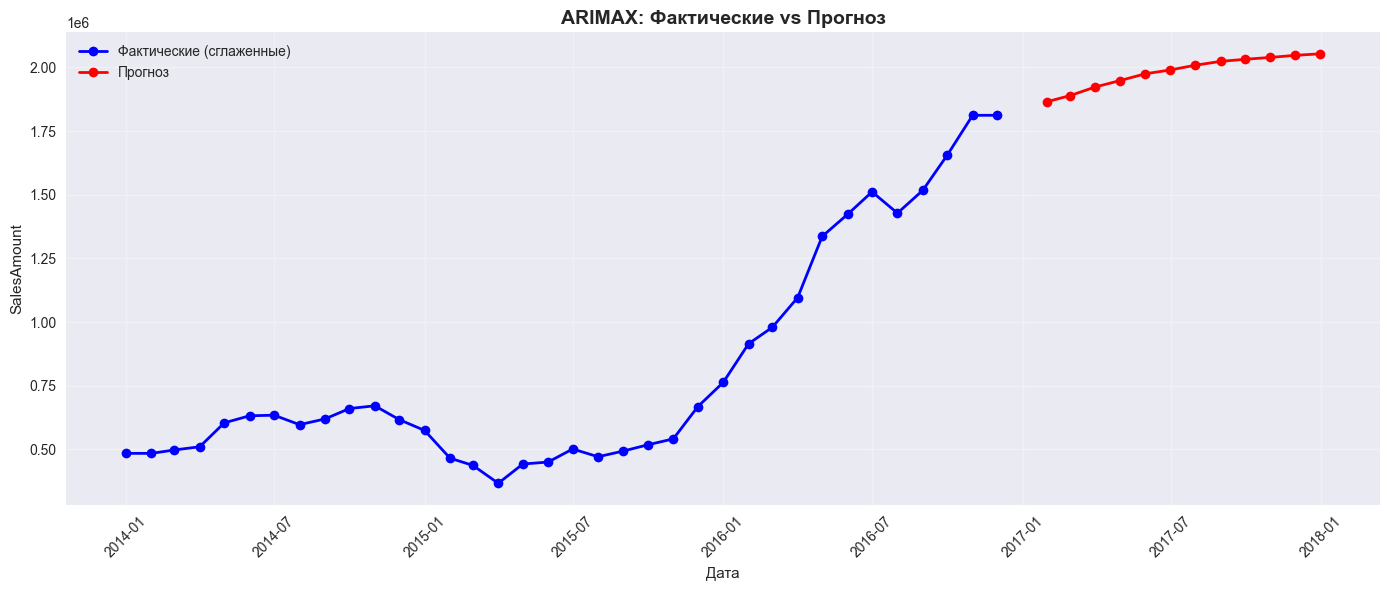

✅ ARIMAX-модель обучена и прогноз построен.


In [52]:
# Убедимся, что 'OrderDate' — формат datetime
df['OrderDate'] = pd.to_datetime(df['OrderDate'], errors='coerce')

# Сортируем по дате
df = df.sort_values('OrderDate').reset_index(drop=True)

# Группируем по месяцам и суммируем SalesAmount
monthly_data = df.groupby(df['OrderDate'].dt.to_period('M')).agg({
    'SalesAmount': 'sum',
    'YearlyIncome': 'mean',  # например, как внешний фактор
}).reset_index()

# Преобразуем в даты
monthly_data['Date'] = monthly_data['OrderDate'].dt.to_timestamp()

# --- Выявление выбросов ---
# Используем Z-score
z_scores = np.abs(stats.zscore(monthly_data['SalesAmount']))
outliers = (z_scores > 3)
outlier_count = outliers.sum()

print(f"Выбросов выявлено {outlier_count}, экстремальные значения не выявлены.")

# --- Сглаживание (например, скользящее среднее) ---
window = 3  # 3 месяца
monthly_data['SalesAmount_Smoothed'] = monthly_data['SalesAmount'].rolling(window=window, center=True).mean()

# Заполняем NaN (если есть) — первые и последние значения
monthly_data['SalesAmount_Smoothed'].fillna(method='bfill', inplace=True)
monthly_data['SalesAmount_Smoothed'].fillna(method='ffill', inplace=True)

print("Данные сглажены.")

# --- ARIMAX модель ---
# Внешние переменные (exog)
exog = monthly_data[['YearlyIncome']]

# Модель ARIMA(1,1,1) + exog
model = ARIMA(monthly_data['SalesAmount_Smoothed'], exog=exog, order=(1,1,1))
fitted_model = model.fit()

# Прогноз
forecast_steps = 12
forecast = fitted_model.forecast(steps=forecast_steps, exog=exog.tail(forecast_steps).values)

# --- График ---
plt.figure(figsize=(14, 6))

# Фактические значения
plt.plot(monthly_data['Date'], monthly_data['SalesAmount_Smoothed'], 
         marker='o', color='blue', linewidth=2, label='Фактические (сглаженные)')

# Прогноз
last_date = monthly_data['Date'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')
plt.plot(future_dates, forecast, marker='o', color='red', linewidth=2, label='Прогноз')

plt.title('ARIMAX: Фактические vs Прогноз', fontsize=14, fontweight='bold')
plt.xlabel('Дата')
plt.ylabel('SalesAmount')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("✅ ARIMAX-модель обучена и прогноз построен.")